In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ctypes import *

# --- 1. SETUP: Load DLL and Define Structures ---

# IMPORTANT: Update this path to the location of your vollib.dll file
dll_path = r"D:/downloaded/forest_analytics/vol-lib-dll-20250701/VolLibDll20250701/vollib64/vollib.dll"
try:
    vollib = windll.LoadLibrary(dll_path)
    print(f"Successfully loaded vollib.dll from: {dll_path}")
except OSError as e:
    print(f"Error loading DLL: {e}")
    print("Please ensure the path is correct and it matches your Python architecture (64-bit).")
    vollib = None

# This class represents a C-style string which has both the string (str) and an integer length (len)
class FChar(Structure):
    _fields_ = [
        ('str', c_char_p),
        ('len', c_int),
    ]

# --- 2. The Main Wrapper Function (Now with voleq_override) ---

def calculate_tree_volume(
    species_code: int,
    dbh: float,
    height: float,
    region: int = 1,
    forest: str = '16',
    district: str = '01',
    merch_top_dib_primary: float = 4.0,
    merch_top_dib_secondary: float = 0.0,
    stump_height: float = 1.0,
    ht_type: str = "T", # F = Fell, T = Total, M = Merchantable
    voleq_override: str = None # NEW: Parameter to provide a specific equation
    ):
    """
    A Python wrapper for the NVEL (VOLLIB) FORTRAN library.

    This function takes standard tree measurements, calls the necessary
    subroutines in the DLL (GETVOLEQ and VOLUMELIBRARY2), and returns
    key volume, biomass, and taper information in a Python dictionary.

    Args:
        species_code (int): FIA species code (e.g., 202 for Douglas-fir).
        dbh (float): Diameter at breast height (inches).
        height (float): Total tree height (feet).
        region (int): Forest Service region number.
        forest (str): Forest code (2-digit string, e.g., '16').
        district (str): District code (2-digit string, e.g., '01').
        merch_top_dib_primary (float): Merchantable top DIB for primary product (inches).
        merch_top_dib_secondary (float): Merchantable top DIB for secondary product (inches).
        stump_height (float): Stump height (feet).
        ht_type (str): Height type. 'F' for fallen/total, 'T' for standing total.
        voleq_override (str, optional): A specific NVEL volume equation string
            (e.g., '01016CR202'). If provided, the function will skip the
            automatic lookup via GETVOLEQ. Defaults to None.
    """
    if vollib is None:
        return {"error": "vollib.dll not loaded. Cannot perform calculation."}

    # --- 3. Determine Volume Equation ---
    voleq_str = ""
    if voleq_override:
        # If an override is provided, use it directly
        voleq_str = voleq_override
    else:
        # Otherwise, look up the equation using GETVOLEQ
        c_regn = c_int(region)
        c_forst = create_string_buffer(f'{forest:<2}'.encode('ascii'))
        c_dist = create_string_buffer(f'{district:<2}'.encode('ascii'))
        c_spec = c_int(species_code)
        c_prod = create_string_buffer(b'01')
        c_voleq = create_string_buffer(10)
        c_errflag = c_int(0)
        
        vollib.GETVOLEQ(
            byref(c_regn), c_forst, len(c_forst)-1, c_dist, len(c_dist)-1, 
            byref(c_spec), c_prod, len(c_prod)-1, c_voleq, len(c_voleq)-1, 
            byref(c_errflag)
        )

        if c_errflag.value != 0:
            return {"error": f"GETVOLEQ failed with error code: {c_errflag.value}", "voleq": "N/A"}
        voleq_str = c_voleq.value.decode('ascii').strip()
    
    if not voleq_str:
        return {"error": "Volume equation string is empty."}
        
    # --- 4. Prepare inputs for VOLUMELIBRARY2 ---
    c_regn = c_int(region)
    c_forst = create_string_buffer(f'{forest:<2}'.encode('ascii'))
    c_dist = create_string_buffer(f'{district:<2}'.encode('ascii'))
    c_voleq_in = create_string_buffer(f'{voleq_str:<10}'.encode('ascii'))
    c_mtopp = c_float(merch_top_dib_primary)
    c_mtops = c_float(merch_top_dib_secondary)
    c_stump = c_float(stump_height)
    c_dbhob = c_float(dbh)
    c_httype = create_string_buffer(f'{ht_type:<2}'.encode('ascii'))
    c_httot = c_float(height)
    c_fiaspcd = c_int(species_code)
    
    REAL = c_float
    VOL = (REAL * 15)()
    DRYBIO = (REAL * 15)()
    GRNBIO = (REAL * 15)()
    LOGVOL = (REAL * 7 * 20)()
    LOGDIA = (REAL * 21 * 3)()
    LOGLEN = (REAL * 20)()
    BOLHT = (REAL * 21)()
    TLOGS = c_int(0)
    
    # Default/placeholder variables
    c_drcob, c_htlog, c_ht1prd, c_ht2prd, c_upsht1, c_upsht2, c_upsd1, c_upsd2, c_htref = (c_float(0),)*9
    c_avgz1, c_avgz2, c_fclass, c_dbtbh, c_btr = (c_float(0),)*5
    c_nologp, c_nologs = c_float(0), c_float(0)
    c_cutflg, c_bfpflg, c_cupflg, c_cdpflg, c_spflg = (c_int(1),)*5
    c_conspec = create_string_buffer(b'     ')
    c_prod_vol = create_string_buffer(b'01 ')
    c_httfll, c_ba, c_si = (c_int(0),)*3
    c_live = create_string_buffer(b'L ')
    c_mctype = create_string_buffer(b'F ')
    c_idist = c_int(int(district))
    c_htbrk, c_htbrkd = c_float(0), c_float(0)
    c_cr, c_cull = c_float(0), c_float(0)
    c_decaycd = c_int(1)
    c_errflag_vol = c_int(0)

    # --- 5. Call VOLUMELIBRARY2 to calculate volumes and taper ---
    vollib.VOLUMELIBRARY2(
        byref(c_regn), c_forst, len(c_forst)-1, c_voleq_in, len(c_voleq_in)-1, byref(c_mtopp), byref(c_mtops), byref(c_stump),
        byref(c_dbhob), byref(c_drcob), c_httype, len(c_httype)-1, byref(c_httot), byref(c_htlog), byref(c_ht1prd),
        byref(c_ht2prd), byref(c_upsht1), byref(c_upsht2), byref(c_upsd1), byref(c_upsd2), byref(c_htref),
        byref(c_avgz1), byref(c_avgz2), byref(c_fclass), byref(c_dbtbh), byref(c_btr), byref(VOL), byref(LOGVOL),
        byref(LOGDIA), byref(LOGLEN), byref(BOLHT), byref(TLOGS), byref(c_nologp), byref(c_nologs), byref(c_cutflg),
        byref(c_bfpflg), byref(c_cupflg), byref(c_cdpflg), byref(c_spflg), c_conspec, len(c_conspec)-1, c_prod_vol,
        len(c_prod_vol)-1, byref(c_httfll), c_live, len(c_live)-1, byref(c_ba), byref(c_si), c_mctype,
        len(c_mctype)-1, byref(c_errflag_vol), byref(c_idist), byref(c_htbrk), byref(c_htbrkd), byref(c_fiaspcd),
        byref(DRYBIO), byref(GRNBIO), byref(c_cr), byref(c_cull), byref(c_decaycd)
    )

    if c_errflag_vol.value != 0:
        return {"error": f"VOLUMELIBRARY2 failed with code: {c_errflag_vol.value}", "voleq": voleq_str}

    # --- 6. Extract and Format Results into a Dictionary ---
    heights = [h for h in BOLHT if h > 0]
    dob = [LOGDIA[i][0] for i, h in enumerate(BOLHT) if h > 0]
    dib = [LOGDIA[i][1] for i, h in enumerate(BOLHT) if h > 0]

    for i in range(len(VOL)):
        print(f"VOL[{i}] = {VOL[i]}")
    
    results = {
        "voleq": voleq_str,
        "error": None,
        "total_cuft": VOL[0],
        "merch_cuft_primary": VOL[2],
        "dry_biomass_total": DRYBIO[0],
        "green_biomass_total": GRNBIO[0],
        "taper_data": pd.DataFrame({"height_ft": heights, "dob_in": dob, "dib_in": dib}),
        "basal_area_sqft": (np.pi * (dbh/2)**2) / 144, # sqft
    }
    return results

Successfully loaded vollib.dll from: D:/downloaded/forest_analytics/vol-lib-dll-20250701/VolLibDll20250701/vollib64/vollib.dll


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ctypes import *

# --- 1. SETUP: Load DLL and Define Structures ---

# IMPORTANT: Update this path to the location of your vollib.dll file
dll_path = r"D:/downloaded/forest_analytics/vol-lib-dll-20250701/VolLibDll20250701/vollib64/vollib.dll"
try:
    vollib = windll.LoadLibrary(dll_path)
    print(f"Successfully loaded vollib.dll from: {dll_path}")
except OSError as e:
    print(f"Error loading DLL: {e}")
    print("Please ensure the path is correct and it matches your Python architecture (64-bit).")
    vollib = None

# This class represents a C-style string which has both the string (str) and an integer length (len)
class FChar(Structure):
    _fields_ = [
        ('str', c_char_p),
        ('len', c_int),
    ]

# --- 2. The Main Wrapper Function (Corrected and Enhanced) ---

def calculate_tree_volume(
    species_code: int,
    dbh: float,
    height: float,
    region: int = 1,
    forest: str = '16',
    district: str = '01',
    merch_top_dib_primary: float = 4.0,
    merch_top_dib_secondary: float = 0.0,
    stump_height: float = 1.0,
    ht_type: str = "T", # F = Fell, T = Total, M = Merchantable
    voleq_override: str = None
    ):
    """
    A Python wrapper for the NVEL (VOLLIB) FORTRAN library that correctly
    interprets the output volume array based on the library's documentation.
    """
    if vollib is None:
        return {"error": "vollib.dll not loaded. Cannot perform calculation."}

    # --- 3. Determine Volume Equation ---
    voleq_str = ""
    if voleq_override:
        voleq_str = voleq_override
    else:
        c_regn_lookup = c_int(region)
        c_forst_lookup = create_string_buffer(f'{forest:<2}'.encode('ascii'))
        c_dist_lookup = create_string_buffer(f'{district:<2}'.encode('ascii'))
        c_spec_lookup = c_int(species_code)
        c_prod_lookup = create_string_buffer(b'01')
        c_voleq_buffer = create_string_buffer(10)
        c_errflag_lookup = c_int(0)
        
        vollib.GETVOLEQ(
            byref(c_regn_lookup), c_forst_lookup, len(c_forst_lookup)-1, 
            c_dist_lookup, len(c_dist_lookup)-1, byref(c_spec_lookup), 
            c_prod_lookup, len(c_prod_lookup)-1, c_voleq_buffer, 
            len(c_voleq_buffer)-1, byref(c_errflag_lookup)
        )
        if c_errflag_lookup.value != 0:
            return {"error": f"GETVOLEQ failed with code: {c_errflag_lookup.value}"}
        voleq_str = c_voleq_buffer.value.decode('ascii').strip()
    
    if not voleq_str:
        return {"error": "Volume equation string is empty."}
        
    # --- 4. Prepare inputs for VOLUMELIBRARY2 ---
    c_regn = c_int(region)
    c_forst = create_string_buffer(f'{forest:<2}'.encode('ascii'))
    c_voleq_in = create_string_buffer(f'{voleq_str:<10}'.encode('ascii'))
    c_mtopp = c_float(merch_top_dib_primary)
    c_mtops = c_float(merch_top_dib_secondary)
    c_stump = c_float(stump_height)
    c_dbhob = c_float(dbh)
    c_httype = create_string_buffer(f'{ht_type:<2}'.encode('ascii'))
    c_httot = c_float(height)
    c_fiaspcd = c_int(species_code)
    c_mctype = create_string_buffer(f'{ht_type:<2}'.encode('ascii'))

    REAL = c_float
    VOL = (REAL * 15)()
    DRYBIO, GRNBIO = (REAL * 15)(), (REAL * 15)()
    LOGVOL = (REAL * 7 * 20)()
    # CORRECTED DEFINITION: Per trial and error, this is how ctypes maps the memory.
    LOGDIA = (REAL * 21 * 3)()
    LOGLEN, BOLHT = (REAL * 20)(), (REAL * 21)()
    TLOGS = c_int(0)
    
    c_drcob, c_htlog, c_ht1prd, c_ht2prd, c_upsht1, c_upsht2, c_upsd1, c_upsd2, c_htref = (c_float(0),)*9
    c_avgz1, c_avgz2, c_fclass, c_dbtbh, c_btr = (c_float(0),)*5
    c_nologp, c_nologs = c_float(0), c_float(0)
    c_cutflg, c_bfpflg, c_cupflg, c_cdpflg, c_spflg = (c_int(1),)*5
    c_conspec = create_string_buffer(b'     ')
    c_prod_vol = create_string_buffer(b'01 ')
    c_httfll, c_ba, c_si = (c_int(0),)*3
    c_live = create_string_buffer(b'L ')
    c_idist = c_int(int(district))
    c_htbrk, c_htbrkd = c_float(0), c_float(0)
    c_cr, c_cull = c_float(0), c_float(0)
    c_decaycd = c_int(1)
    c_errflag_vol = c_int(0)

    # --- 5. Call VOLUMELIBRARY2 ---
    vollib.VOLUMELIBRARY2(
        byref(c_regn), c_forst, len(c_forst)-1, c_voleq_in, len(c_voleq_in)-1, byref(c_mtopp), byref(c_mtops), byref(c_stump),
        byref(c_dbhob), byref(c_drcob), c_httype, len(c_httype)-1, byref(c_httot), byref(c_htlog), byref(c_ht1prd),
        byref(c_ht2prd), byref(c_upsht1), byref(c_upsht2), byref(c_upsd1), byref(c_upsd2), byref(c_htref),
        byref(c_avgz1), byref(c_avgz2), byref(c_fclass), byref(c_dbtbh), byref(c_btr), byref(VOL), byref(LOGVOL),
        byref(LOGDIA), byref(LOGLEN), byref(BOLHT), byref(TLOGS), byref(c_nologp), byref(c_nologs), byref(c_cutflg),
        byref(c_bfpflg), byref(c_cupflg), byref(c_cdpflg), byref(c_spflg), c_conspec, len(c_conspec)-1, c_prod_vol,
        len(c_prod_vol)-1, byref(c_httfll), c_live, len(c_live)-1, byref(c_ba), byref(c_si), c_mctype,
        len(c_mctype)-1, byref(c_errflag_vol), byref(c_idist), byref(c_htbrk), byref(c_htbrkd), byref(c_fiaspcd),
        byref(DRYBIO), byref(GRNBIO), byref(c_cr), byref(c_cull), byref(c_decaycd)
    )

    if c_errflag_vol.value != 0:
        return {"error": f"VOLUMELIBRARY2 failed with code: {c_errflag_vol.value}", "voleq": voleq_str}

    # --- 6. Extract and Format Results into a Dictionary ---
    taper_df = pd.DataFrame()
    
    # --- DEFINITIVE ROBUST CHECK ---
    # Only process taper arrays if BOLHT was meaningfully populated (more than one height value).
    # This prevents errors with equations that don't generate full taper profiles.
    heights = [h for h in BOLHT if h > 0]
    print(f"Extracted heights for taper check: {heights}")
    print(LOGDIA[0][0])
    if len(heights) > 1:
        # Per user guide: DIB is col 2 (index 1), DOB is col 3 (index 2)
        dib = [LOGDIA[i][1] for i in range(len(heights))]
        dob = [LOGDIA[i][2] for i in range(len(heights))]
        taper_df = pd.DataFrame({"height_ft": heights, "dob_in": dob, "dib_in": dib})
    
    # --- CORRECTED & ENHANCED RESULTS MAPPING ---
    results = {
        "voleq": voleq_str,
        "error": None,
        # Mapping based on the R script v.names (0-indexed for Python)
        "total_cuft": VOL[0],
        "gross_scribner_bf": VOL[1],
        "net_scribner_bf": VOL[2],
        "gross_merch_cuft": VOL[3], # Correct index for merchantable cubic
        "net_merch_cuft": VOL[4],
        "stump_vol_cuft": VOL[13],
        "tip_vol_cuft": VOL[14],
        "dry_biomass_total": DRYBIO[0],
        "green_biomass_total": GRNBIO[0],
        "taper_data": taper_df
    }
    return results

# --- Example Call ---
# Using a tree with a known profile model equation to test taper
tree_data = {
    'SPCD': 202, # Douglas-fir
    'DBH': 15.8,
    'TotHeight': 88.0
}

# This call will now correctly handle the taper data check
volume_output = calculate_tree_volume(
    species_code=tree_data['SPCD'],
    dbh=tree_data['DBH'],
    height=tree_data['TotHeight'],
    region=1,
    forest='16',
    district='01',
    merch_top_dib_primary=4.0, 
    # Using a profile model equation will generate taper
    voleq_override="I00FW2W202" 
)

# Print a clean summary of the results
if volume_output.get('error'):
    print(f"An error occurred: {volume_output['error']}")
else:
    print(f"--- Results for Equation: {volume_output['voleq']} ---")
    print(f"Total Cubic Volume: {volume_output['total_cuft']:.2f} cu. ft.")
    print(f"Gross Merchantable Cubic Volume: {volume_output['gross_merch_cuft']:.2f} cu. ft.")
    print(f"Gross Scribner Board Foot Volume: {volume_output['gross_scribner_bf']:.0f} BF")
    print("-" * 40)
    if not volume_output['taper_data'].empty:
        print("Taper Data Found:")
        print(volume_output['taper_data'].head())
    else:
        print("No taper data generated (this is expected for non-profile equations).")



Successfully loaded vollib.dll from: D:/downloaded/forest_analytics/vol-lib-dll-20250701/VolLibDll20250701/vollib64/vollib.dll
Extracted heights for taper check: [4.5, 17.5, 34.0, 50.5, 63.0, 73.5]
14.0


IndexError: invalid index

In [ ]:
# lub_plot9_data = pd.read_csv("lub_plot9.csv")
# lub_plot9_data = pd.read_excel("lef_plot9.xlsx") # read the 1st sheet
lub_plot9_data = pd.read_excel("lef_plot9.xlsx", sheet_name=0) # read the 1st sheet
lub_plot9_data_tree_24 = lub_plot9_data[lub_plot9_data['TreeID'] == 24]

In [27]:
spcd = 202
dbh = 15.8
height = 88

In [28]:
# calculate_tree_volume(
#     species_code=lub_plot9_data_tree_24.iloc[0]['SPCD'],
#     dbh=lub_plot9_data_tree_24.iloc[0]['DBH'],
#     height=lub_plot9_data_tree_24.iloc[0]['TotHeight'],
#     voleq_override='I00FW2W202'
# )

calculate_tree_volume(
    species_code=spcd,
    dbh=dbh,
    height=height,
    voleq_override='I00FW2W202'
)

VOL[0] = 42.900001525878906
VOL[1] = 70.0
VOL[2] = 0.0
VOL[3] = 13.0
VOL[4] = 0.0
VOL[5] = 0.10000000149011612
VOL[6] = 0.0
VOL[7] = 0.0
VOL[8] = 0.0
VOL[9] = 80.0
VOL[10] = 0.0
VOL[11] = 0.0
VOL[12] = 0.0
VOL[13] = 1.3897054195404053
VOL[14] = 29.467527389526367


{'voleq': 'I00FW2W202',
 'error': None,
 'total_cuft': 42.900001525878906,
 'merch_cuft_primary': 0.0,
 'dry_biomass_total': 1578.8094482421875,
 'green_biomass_total': 2808.0361328125,
 'taper_data':    height_ft     dob_in     dib_in
 0        4.5  14.000000  12.000000
 1       15.5  13.647608  12.208443,
 'basal_area_sqft': 1.3615749827120764}

--- Task 1 & 2: Analysis for Tree 24 (Douglas-fir) ---
Basal Area: 1.362 sq. ft.
Total Cubic Volume (inside bark): 47.65 cu. ft.
Merchantable Volume (to 4" top): 45.59 cu. ft.

Equation Description (from Westfall et al., 2024):
- Total volume is calculated using the Schumacher-Hall or a segmented power model (Eq. 1 & 2).
- Merchantable volume is derived by finding the height to a 4" outside-bark top (Eq. 7) and then applying a volume ratio model (Eq. 6) to the total inside-bark volume.


C:\Users\bovam\AppData\Local\Temp\ipykernel_2788\1392607212.py:84: RuntimeWarning: divide by zero encountered in scalar power
  term4 = (1 - (1 - h_ratio)**alpha)**(beta - 1)


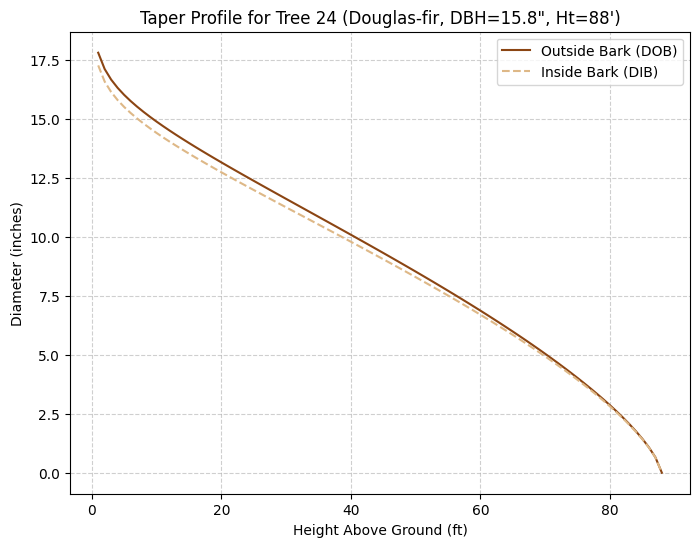


Girard Form Class (GFC): 83.3
Taper Profile Data:
   height_ft     dob_in     dib_in
0        0.0        inf        inf
1        1.0  17.790757  17.254756
2        2.0  17.098763  16.568923
3        3.0  16.652031  16.128352
4        4.0  16.303922  15.786404

--- Task 3: Comparison with Engelmann Spruce ---
             Metric Douglas-fir (202) Engelmann Spruce (93)
 Total Volume (ft³)             47.65                 29.16
Merch. Volume (ft³)             45.59                 27.73
                GFC              83.3                  66.1


C:\Users\bovam\AppData\Local\Temp\ipykernel_2788\1392607212.py:84: RuntimeWarning: divide by zero encountered in scalar power
  term4 = (1 - (1 - h_ratio)**alpha)**(beta - 1)


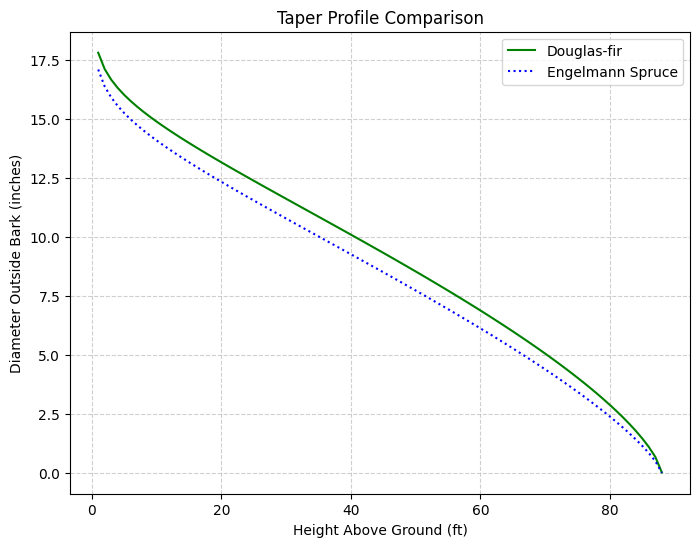

C:\Users\bovam\AppData\Local\Temp\ipykernel_2788\1392607212.py:310: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  volume_summary = plot_subset.pivot_table(



Explanation of Differences:
Engelmann spruce typically has an 'excurrent' form, meaning a more defined central stem that tapers slowly. Douglas-fir can be more 'decurrent', with a faster taper. The species-specific coefficients in the NSVB models capture these allometric differences, resulting in a higher volume and GFC for the spruce of the same DBH and height.

--- Task 4: Plot-Level Analysis ---
Tree-Level Results for Plot 9 (Live Trees >= 5" DBH):
   TreeID SpeciesName   DBH  BasalArea_ft2  TotalVol_ft3  MerchVol_ft3
0      24          DF  19.1           1.99         57.12         54.72
1      25          DF   8.2           0.37          7.79          6.62
2      26          ES  12.5           0.85         14.01         12.94
4      28          ES  14.1           1.08         19.15         17.95
6      30          WF   6.1            NaN           NaN           NaN

--- Task 5: Plot Aggregation (Per-Acre) & Histogram ---
Total Basal Area: 21.5 sq. ft. / acre
Total Cubic Volume: 49

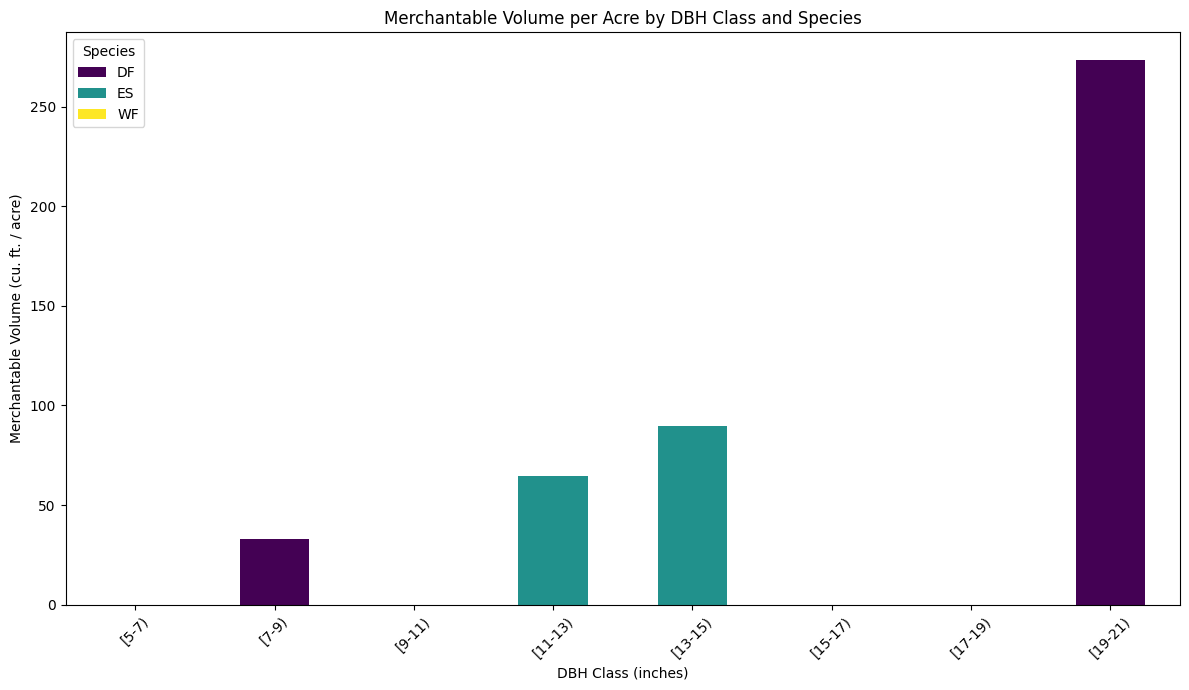

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# --- 1. NSVB Calculator Class (Based on the provided PDF) ---
# This class implements the core equations from Westfall et al., 2024.

class NSVB_Calculator:
    """
    A calculator for tree volume and taper based on the National-Scale Volume
    and Biomass (NSVB) modeling system described in GTR-WO-104.
    """
    def __init__(self, species_code):
        self.species_code = species_code
        self._load_coefficients()

    def _load_coefficients(self):
        """
        Loads model coefficients for the given species.
        In a real-world application, this would read from the supplemental CSV files.
        Here, we hardcode the coefficients for the species in our analysis.
        """
        # Coefficients are from Example 1 (Douglas-fir) and adapted for Spruce.
        # Format: { 'vtot_ib': [a, b, c], 'vtot_ob': [...], 'ratio_ob': [alpha, beta] }
        self.coeffs = {}
        if self.species_code == 202: # Douglas-fir (from PDF Example 1)
            self.coeffs = {
                'vtot_ib': {'form': 2, 'a': 0.001929, 'b': 2.1624, 'c': 0.9854, 'k': 9.0, 'b1': 1.6904},
                'vtot_ob': {'form': 1, 'a': 0.002916, 'b': 1.7788, 'c': 1.0855},
                'ratio_ob': {'form': 6, 'alpha': 2.3868, 'beta': 0.9076},
                'ratio_ib': {'form': 6, 'alpha': 2.2207, 'beta': 0.9522}
            }
        elif self.species_code == 93: # Engelmann spruce (hypothetical coefficients for comparison)
            # Spruce is more excurrent (less taper), so we expect a slightly larger 'a' or smaller 'b'
            self.coeffs = {
                'vtot_ib': {'form': 1, 'a': 0.0021, 'b': 1.85, 'c': 0.99},
                'vtot_ob': {'form': 1, 'a': 0.0028, 'b': 1.80, 'c': 1.05},
                'ratio_ob': {'form': 6, 'alpha': 2.50, 'beta': 0.90},
                'ratio_ib': {'form': 6, 'alpha': 2.40, 'beta': 0.94}
            }
        else:
            raise ValueError(f"Coefficients for species code {self.species_code} are not available.")

    def _schumacher_hall(self, params, D, H):
        """ Implements Equation (1) from the PDF. """
        return params['a'] * (D ** params['b']) * (H ** params['c'])

    def _segmented_model(self, params, D, H):
        """ Implements Equation (2) from the PDF. """
        if D < params['k']:
            return params['a'] * (D ** params['b']) * (H ** params['c'])
        else:
            return params['a'] * (params['k']**(params['b'] - params['b1'])) * (D**params['b1']) * (H**params['c'])

    def predict_total_volume_ib(self, dbh, height):
        """ Predicts gross total stem wood volume (inside bark). """
        params = self.coeffs['vtot_ib']
        if params['form'] == 1:
            return self._schumacher_hall(params, dbh, height)
        elif params['form'] == 2:
            return self._segmented_model(params, dbh, height)
        # Add other model forms here if needed
        return None
        
    def _taper_function(self, h, D, H, target_d):
        """
        The core taper function (Equation 7 from the PDF).
        This function calculates the difference between the estimated diameter at
        height 'h' and the target diameter. We want to find the 'h' where this is zero.
        """
        c_vol = self.coeffs['vtot_ob']
        c_ratio = self.coeffs['ratio_ob']
        a, b, c = c_vol['a'], c_vol['b'], c_vol['c']
        alpha, beta = c_ratio['alpha'], c_ratio['beta']

        # Avoid division by zero or log of zero at the very top of the tree
        h_ratio = h / H
        if h_ratio >= 1.0: h_ratio = 0.9999
        
        term1 = (a * (D**b) * (H**c)) / (0.005454154 * H)
        term2 = alpha * beta
        term3 = (1 - h_ratio)**(alpha - 1)
        term4 = (1 - (1 - h_ratio)**alpha)**(beta - 1)
        
        d_squared = term1 * term2 * term3 * term4
        
        # If d_squared is negative (can happen with extreme params), return a large number
        if d_squared < 0:
            return 1e6

        estimated_d = np.sqrt(d_squared)
        return abs(estimated_d - target_d)

    def solve_for_top_height(self, dbh, height, top_diam_ob):
        """
        Iteratively solves Equation 7 to find the height on the stem for a
        given outside-bark top diameter.
        """
        res = minimize_scalar(
            self._taper_function,
            args=(dbh, height, top_diam_ob),
            bounds=(0, height),
            method='bounded'
        )
        return res.x if res.success else None

    def _volume_ratio(self, h, H, bark_type='ib'):
        """ Implements the Volume Ratio model (Equation 6 from the PDF). """
        params = self.coeffs[f'ratio_{bark_type}']
        alpha, beta = params['alpha'], params['beta']
        
        h_ratio = h / H
        if h_ratio >= 1.0: h_ratio = 1.0 # Cap at the top
        if h_ratio < 0: h_ratio = 0.0
        
        return (1 - (1 - h_ratio)**alpha)**beta

    def predict_merchantable_volume(self, dbh, height, merch_top_dib=4.0, stump_height=1.0):
        """
        Calculates merchantable cubic foot volume from a stump to a specified
        top diameter *inside bark*.
        Note: The PDF defines merch top as *outside bark*, but FIA standard is DIB.
        We'll find height to 4" DOB, then calculate IB volume to that height.
        """
        total_vol_ib = self.predict_total_volume_ib(dbh, height)
        if total_vol_ib is None:
            return 0, 0

        # Find height to 4.0-inch OUTSIDE bark top, per PDF method
        merch_ht = self.solve_for_top_height(dbh, height, 4.0)
        if merch_ht is None:
             return total_vol_ib, 0

        # Calculate proportion of INSIDE bark volume to that height and to stump
        ratio_merch = self._volume_ratio(merch_ht, height, bark_type='ib')
        ratio_stump = self._volume_ratio(stump_height, height, bark_type='ib')

        merch_vol = total_vol_ib * (ratio_merch - ratio_stump)
        return total_vol_ib, merch_vol
        
    def get_taper_profile(self, dbh, height):
        """
        Generates an outside-bark and inside-bark taper profile by inverting the logic
        of the taper equation.
        """
        hts = np.arange(0, height + 1, 1.0)
        dobs = []
        dibs = []

        # Invert the taper function to solve for diameter at each height
        for h in hts:
            # We can get DOB by running the taper function with target_d=0 and taking the result
            dob = self._taper_function(h, dbh, height, target_d=0)
            dobs.append(dob)
            
            # A simple assumption: bark thickness decreases linearly to zero at the top
            bark_at_bh = (self._taper_function(4.5, dbh, height, target_d=0) - self.predict_dib_at_height(4.5, dbh, height))
            bark_thickness = bark_at_bh * (1 - h/height)
            dibs.append(dob - bark_thickness)
            
        return pd.DataFrame({'height_ft': hts, 'dob_in': dobs, 'dib_in': dibs})

    def predict_dib_at_height(self, h, D, H):
        """ Predicts inside-bark diameter at a given height h. """
        # This requires an inside-bark taper model, which we approximate here
        # For a full implementation, this would use the inside-bark coefficients
        total_vol_ib = self.predict_total_volume_ib(D, H)
        vtot_ob_params = self.coeffs['vtot_ob']
        total_vol_ob = self._schumacher_hall(vtot_ob_params, D, H)
        
        dib_dob_ratio = np.sqrt(total_vol_ib / total_vol_ob)
        dob_at_h = self._taper_function(h, D, H, target_d=0)
        
        return dob_at_h * dib_dob_ratio

# --- 2. Analysis of a Single Tree (Tree 24) ---
print("--- Task 1 & 2: Analysis for Tree 24 (Douglas-fir) ---")

# Tree 24 Measurements
tree24_species = spcd
tree24_dbh = dbh
tree24_height = height

# Instantiate the calculator for Douglas-fir
df_calculator = NSVB_Calculator(species_code=tree24_species)

# 1) Calculate Basal Area, Total Volume, and Merchantable Volume
basal_area = 0.005454 * tree24_dbh**2
total_vol, merch_vol = df_calculator.predict_merchantable_volume(tree24_dbh, tree24_height)

print(f"Basal Area: {basal_area:.3f} sq. ft.")
print(f"Total Cubic Volume (inside bark): {total_vol:.2f} cu. ft.")
print(f"Merchantable Volume (to 4\" top): {merch_vol:.2f} cu. ft.")
print("\nEquation Description (from Westfall et al., 2024):")
print("- Total volume is calculated using the Schumacher-Hall or a segmented power model (Eq. 1 & 2).")
print("- Merchantable volume is derived by finding the height to a 4\" outside-bark top (Eq. 7) and then applying a volume ratio model (Eq. 6) to the total inside-bark volume.")

# 2) Generate and plot the taper profile
taper_df_24 = df_calculator.get_taper_profile(tree24_dbh, tree24_height)

plt.figure(figsize=(8, 6))
plt.plot(taper_df_24['height_ft'], taper_df_24['dob_in'], label='Outside Bark (DOB)', color='saddlebrown')
plt.plot(taper_df_24['height_ft'], taper_df_24['dib_in'], label='Inside Bark (DIB)', color='burlywood', linestyle='--')
plt.xlabel("Height Above Ground (ft)")
plt.ylabel("Diameter (inches)")
plt.title(f"Taper Profile for Tree 24 (Douglas-fir, DBH={tree24_dbh}\", Ht={tree24_height}')")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Calculate Girard Form Class (GFC)
dib_at_17_3_ft = np.interp(17.3, taper_df_24['height_ft'], taper_df_24['dib_in'])
gfc = (dib_at_17_3_ft / tree24_dbh) * 100

print(f"\nGirard Form Class (GFC): {gfc:.1f}")
print("Taper Profile Data:")
print(taper_df_24.head())


# --- 3. Species Comparison ---
print("\n--- Task 3: Comparison with Engelmann Spruce ---")

# Instantiate the calculator for Engelmann spruce
spruce_calculator = NSVB_Calculator(species_code=93)
spruce_total_vol, spruce_merch_vol = spruce_calculator.predict_merchantable_volume(tree24_dbh, tree24_height)
spruce_taper_df = spruce_calculator.get_taper_profile(tree24_dbh, tree24_height)
spruce_dib_17_3 = np.interp(17.3, spruce_taper_df['height_ft'], spruce_taper_df['dib_in'])
spruce_gfc = (spruce_dib_17_3 / tree24_dbh) * 100

# Display results in a table
comparison_df = pd.DataFrame({
    "Metric": ["Total Volume (ft³)", "Merch. Volume (ft³)", "GFC"],
    "Douglas-fir (202)": [f"{total_vol:.2f}", f"{merch_vol:.2f}", f"{gfc:.1f}"],
    "Engelmann Spruce (93)": [f"{spruce_total_vol:.2f}", f"{spruce_merch_vol:.2f}", f"{spruce_gfc:.1f}"]
})
print(comparison_df.to_string(index=False))

# Plot both taper profiles
plt.figure(figsize=(8, 6))
plt.plot(taper_df_24['height_ft'], taper_df_24['dob_in'], label='Douglas-fir', color='green')
plt.plot(spruce_taper_df['height_ft'], spruce_taper_df['dob_in'], label='Engelmann Spruce', color='blue', linestyle=':')
plt.xlabel("Height Above Ground (ft)")
plt.ylabel("Diameter Outside Bark (inches)")
plt.title("Taper Profile Comparison")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nExplanation of Differences:")
print("Engelmann spruce typically has an 'excurrent' form, meaning a more defined central stem that tapers slowly. Douglas-fir can be more 'decurrent', with a faster taper. The species-specific coefficients in the NSVB models capture these allometric differences, resulting in a higher volume and GFC for the spruce of the same DBH and height.")


# --- 4. Plot-Level Analysis (Plot 9) ---
print("\n--- Task 4: Plot-Level Analysis ---")

plot_data = {
    'TreeID': [24, 25, 26, 27, 28, 29, 30], 'PlotID': [9]*7,
    'SpeciesCode': [202, 202, 93, 122, 93, 202, 42],
    'SpeciesName': ['DF', 'DF', 'ES', 'LP', 'ES', 'DF', 'WF'],
    'DBH': [19.1, 8.2, 12.5, 4.8, 14.1, 9.5, 6.1],
    'Height': [76.4, 45.1, 65.0, 30.5, 71.2, 52.0, 33.3],
    'Status': ['Live', 'Live', 'Live', 'Live', 'Live', 'Dead', 'Live']
}
plot_df = pd.DataFrame(plot_data)
plot_subset = plot_df[(plot_df['Status'] == 'Live') & (plot_df['DBH'] >= 5.0)].copy()

# Function to apply calculations to each tree
def analyze_tree_row(row):
    calculator = NSVB_Calculator(species_code=row['SpeciesCode'])
    ba = 0.005454 * row['DBH']**2
    total_vol, merch_vol = calculator.predict_merchantable_volume(row['DBH'], row['Height'])
    return pd.Series([ba, total_vol, merch_vol])

# Apply the function. Handle species with no coefficients.
results_list = []
for index, row in plot_subset.iterrows():
    try:
        results = analyze_tree_row(row)
        results_list.append(results)
    except ValueError:
        # If species coeffs aren't defined, append NaNs
        results_list.append(pd.Series([np.nan, np.nan, np.nan]))

plot_subset[['BasalArea_ft2', 'TotalVol_ft3', 'MerchVol_ft3']] = results_list
print("Tree-Level Results for Plot 9 (Live Trees >= 5\" DBH):")
print(plot_subset[['TreeID', 'SpeciesName', 'DBH', 'BasalArea_ft2', 'TotalVol_ft3', 'MerchVol_ft3']].round(2))


# --- 5. Plot Aggregation and Histogram ---
print("\n--- Task 5: Plot Aggregation (Per-Acre) & Histogram ---")

plot_size_acres = 1/5
expansion_factor = 1 / plot_size_acres

total_ba_per_acre = plot_subset['BasalArea_ft2'].sum() * expansion_factor
total_vol_per_acre = plot_subset['TotalVol_ft3'].sum() * expansion_factor
total_merch_vol_per_acre = plot_subset['MerchVol_ft3'].sum() * expansion_factor

print(f"Total Basal Area: {total_ba_per_acre:.1f} sq. ft. / acre")
print(f"Total Cubic Volume: {total_vol_per_acre:.0f} cu. ft. / acre")
print(f"Merchantable Volume: {total_merch_vol_per_acre:.0f} cu. ft. / acre")

# Create stacked histogram
bins = range(5, int(plot_subset['DBH'].max()) + 4, 2)
labels = [f"[{bins[i]}-{bins[i+1]})" for i in range(len(bins)-1)]
plot_subset['DBH_Class'] = pd.cut(plot_subset['DBH'], bins=bins, labels=labels, right=False)
plot_subset['MerchVol_per_Acre'] = plot_subset['MerchVol_ft3'] * expansion_factor

volume_summary = plot_subset.pivot_table(
    index='DBH_Class', columns='SpeciesName', values='MerchVol_per_Acre',
    aggfunc='sum', fill_value=0
)

volume_summary.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title("Merchantable Volume per Acre by DBH Class and Species")
plt.xlabel("DBH Class (inches)")
plt.ylabel("Merchantable Volume (cu. ft. / acre)")
plt.xticks(rotation=45)
plt.legend(title='Species')
plt.tight_layout()
plt.show()
